In [49]:
!pip install tensorflow

In [50]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2.18.0


In [51]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [52]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    )

Found 2152 files belonging to 3 classes.


In [53]:
class_names = dataset.class_names
print(dataset.class_names)
len(dataset) #total batches

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


68

In [54]:
for image_batch,label_batch in dataset.take(1): # dataset.take(1), taking first batch from dataset
    print(image_batch[0].shape) # Accesses the first image in the batch

(256, 256, 3)


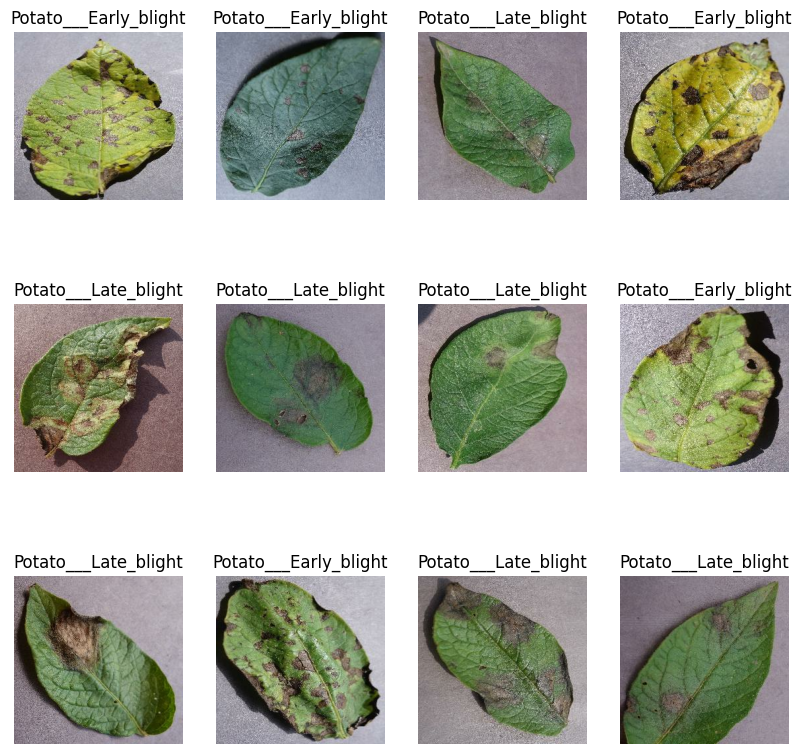

In [55]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [56]:
# 80% -> training
# 20% -> 10% validation, 10% test
train_size = 0.8  
len(dataset)*train_size

54.400000000000006

In [57]:
train_ds = dataset.take(54)
len(train_ds)

54

In [58]:
test_ds = dataset.skip(54) # skip works as arr[54:](slicing)
len(test_ds)

14

In [59]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [60]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [61]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [62]:
def get_data_partitions_tf(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [63]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)
len(train_ds)

54

In [64]:
len(val_ds)

6

In [65]:
len(test_ds)

8

In [66]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [67]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize layer
    layers.Rescaling(1.0/255)  # Rescale layer
])

In [68]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [69]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [70]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\ZaidFaruqui\Desktop\Potato-Disease\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [73]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4602 - loss: 0.9529 - val_accuracy: 0.6719 - val_loss: 0.7702
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.6245 - loss: 0.7383 - val_accuracy: 0.8281 - val_loss: 0.3997
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8744 - loss: 0.3445 - val_accuracy: 0.9062 - val_loss: 0.3493
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9101 - loss: 0.2406 - val_accuracy: 0.9583 - val_loss: 0.1351
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9266 - loss: 0.2214 - val_accuracy: 0.9219 - val_loss: 0.1863
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9410 - loss: 0.1676 - val_accuracy: 0.9688 - val_loss: 0.0758
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1842s 35s/step - accuracy: 0.9704 - loss: 0.1057 - val_accuracy: 0.9323 - val_loss: 0.1834
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9709 - loss: 0.0771 - val_accuracy: 0.8750 -

In [74]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9560 - loss: 0.1113


In [75]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

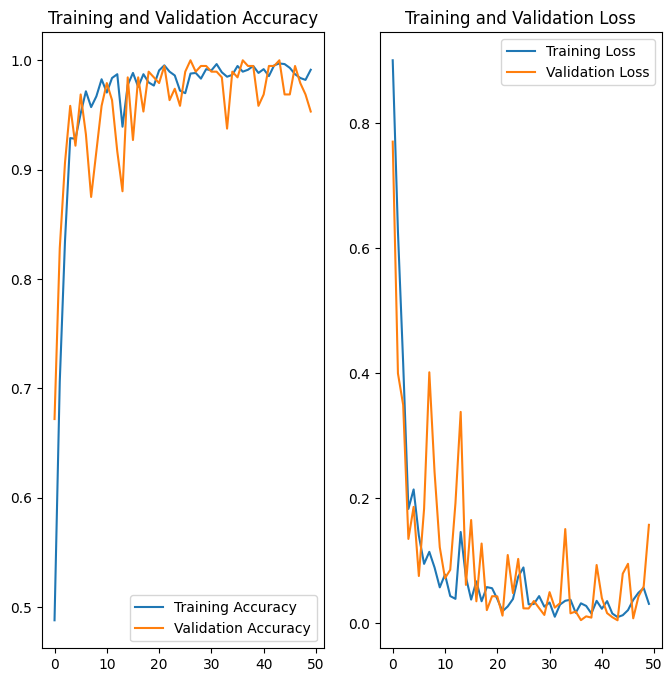

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Potato___Early_blight


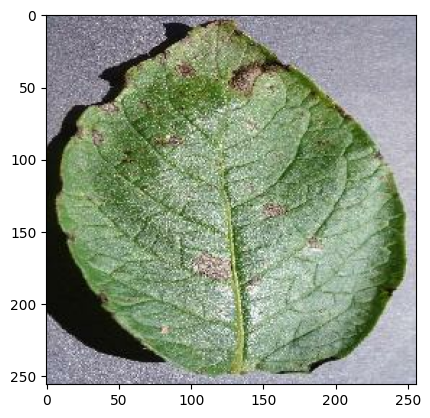

In [78]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [85]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


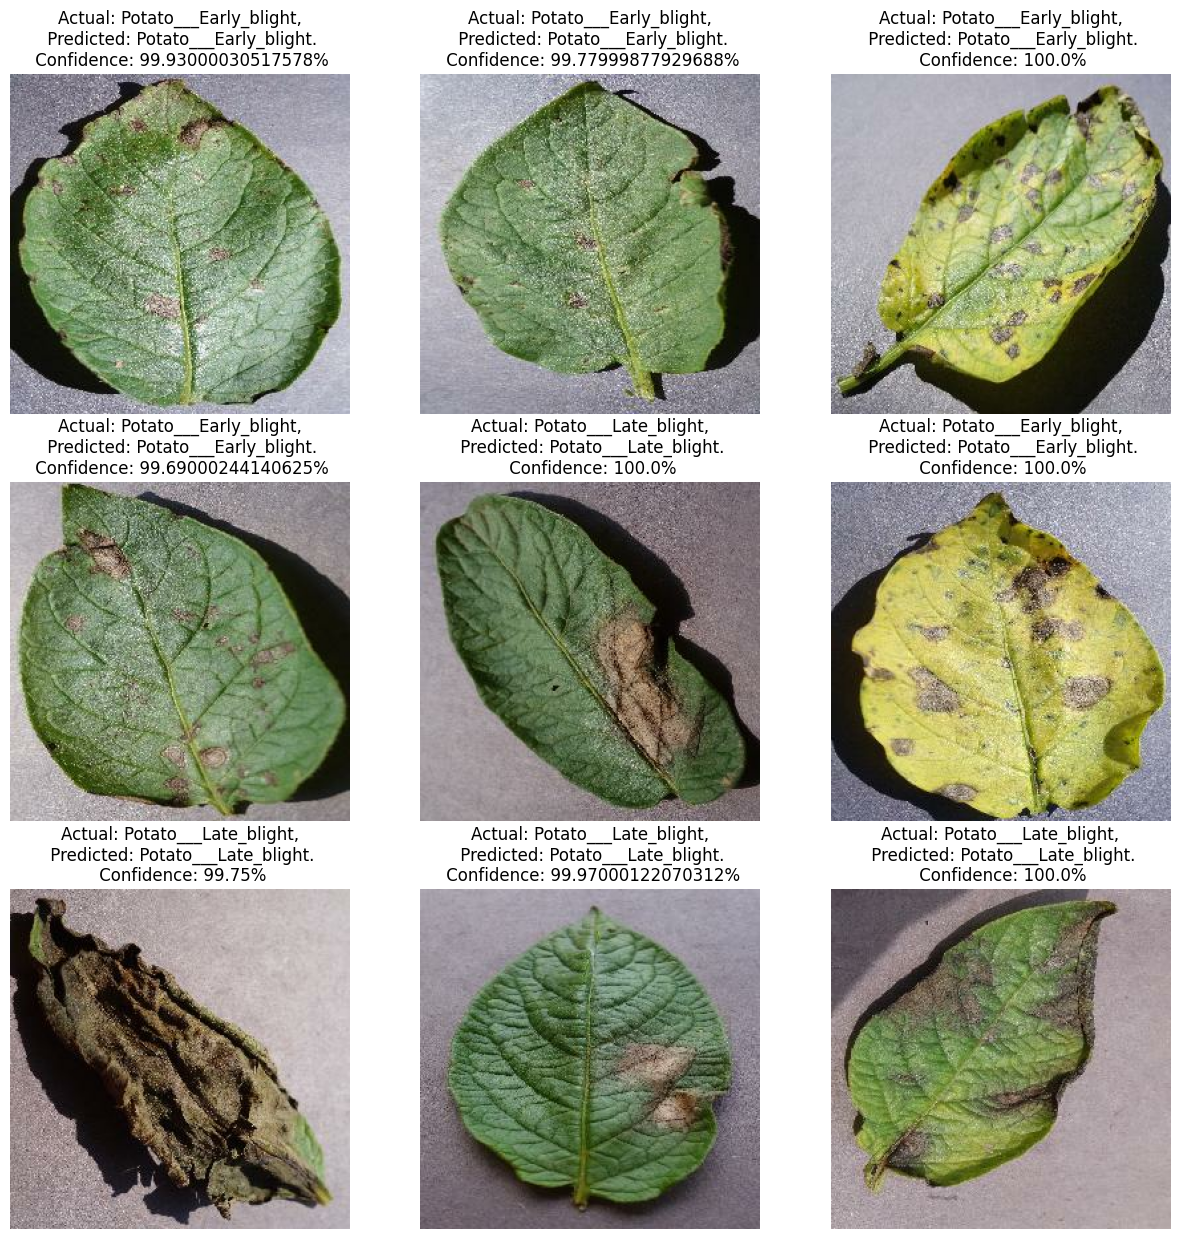

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [110]:
import os
model_version = 1
save_dir = os.path.join("Models", str(model_version))
os.makedirs(save_dir, exist_ok=True)
model.export(save_dir)  # Use export() instead of save() for SavedModel format

INFO:tensorflow:Assets written to: Models\1\assets


INFO:tensorflow:Assets written to: Models\1\assets


Saved artifact at 'Models\1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1562714586768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562714586000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562714586576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562714585616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562838664976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562838666512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562838664208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562838667280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562838667088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562838667856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1562838664784: TensorSpec(shape=(), dtyp